In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  

sns.set_style("whitegrid")

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
path = 'data/processed'
benchmarks_df = pd.read_csv(os.path.join(path, 'a_benchmarks_2024-09-11.csv'))
schools_df = pd.read_csv(os.path.join(path, 'a_schools_2024-08-29.csv'))
courseSections_df = pd.read_csv(os.path.join(path, 'a_courseSections_2024-08-29.csv'))
courseSectionRosters_df = pd.read_csv(os.path.join(path, 'a_courseSectionRosters_2024-08-29.csv'))
scores_df = pd.read_csv(os.path.join(path, 'a_scores_2024-09-11.csv'))
vendorUsage_df = pd.read_csv(os.path.join(path, 'a_vendorUsage_2024-09-11.csv'))

C:\Users\lmmag\AppData\Local\Temp\ipykernel_53284\4073666699.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  courseSectionRosters_df = pd.read_csv(os.path.join(path, 'a_courseSectionRosters_2024-08-29.csv'))


# Preprocess dataframes

## courseSections_df and courseSectionRosters_df
1. Combines the two dataframes on courseSectionId
2. Drops courses that are district-wide or school-wide

In [4]:
courseSectionRosters_df.drop(columns=['id', 'ticket'], inplace=True)
courses = courseSectionRosters_df.merge(courseSections_df, left_on='courseSectionId', right_on='id', how='left')
courses.drop(columns=['id'], inplace=True)
courses = courses[~courses['vanityId'].str.contains('District Wide', case=False, na=False)]
courses = courses[~courses['vanityId'].str.contains('Schoolwide', case=False, na=False)]

## vendorUsage_df
1. Remove unused columns (`weeklyUsageMinutes`, `active`, `id`)
2. Map usageTypeIds to new categorical (ordinal) features (`iready_math`, `iready_reading`, `bbb_literacy`)

In [5]:
vendorUsage_df.head()

,id,vendorId,studentId,active,year,usageTypeId,weeklyUsageMinutes
0,11890,72609,44777,0,2018,1,0
1,11891,72609,44783,0,2018,1,0
2,11892,72609,44784,0,2018,1,0
3,11893,72609,44807,0,2018,1,0
4,11894,72609,44809,0,2018,1,0


In [6]:
# Drop unneded columns (vendorId is represented within usageTypeId)
vendorUsage_df.drop(columns=['vendorId', 'active', 'id', 'weeklyUsageMinutes'], inplace=True)
vendorUsage_df.head()

,studentId,year,usageTypeId
0,44777,2018,1
1,44783,2018,1
2,44784,2018,1
3,44807,2018,1
4,44809,2018,1


In [7]:
vendorUsage_df['usageTypeId'].value_counts()

4     50310
1     47620
3     21983
6     13381
2     10945
5      8014
9      1368
7      1173
12     1117
8       974
10      808
11      273
14       41
Name: usageTypeId, dtype: int64

**Current usageTypeIds:**
- iReady Math User = 6
- iReady Math Partial = 5
- iReadyMath nonUser = 4
- iReady Reading user = 3
- iReady Reading partial = 2 
- iReady reading nonuser = 1
- BBB Literacy User = 9
- BBB Literacy Partial = 8
- BBB Literacy nonUser = 7
- will drop rest of usageTypeIds (10, 11, 12, 14)

**New mapping:**

`iready_math` (new feature)
- 0 nonUser
- 1 partial
- 2 user

`iready_reading` (new feature)
- 0 nonUser
- 1 partial
- 2 user

`bbb_literacy` (new feature)
- 0 nonUser
- 1 partial
- 2 user

In [8]:
iready_math_mapping = {
    4: 0,  # nonUser
    5: 1,  # partial
    6: 2   # user
}

# Mapping for iReady Reading
iready_reading_mapping = {
    1: 0,  # nonUser
    2: 1,  # partial
    3: 2   # user
}

bbb_literacy_mapping = {
    7: 0,  # nonUser
    8: 1,  # partial
    9: 2   # user
}

vendorUsage_df['iready_math'] = 0
vendorUsage_df['iready_reading'] = 0
vendorUsage_df['bbb_literacy'] = 0

vendorUsage_df['iready_math'] = vendorUsage_df['usageTypeId'].map(iready_math_mapping).fillna(0)
vendorUsage_df['iready_reading'] = vendorUsage_df['usageTypeId'].map(iready_reading_mapping).fillna(0)
vendorUsage_df['bbb_literacy'] = vendorUsage_df['usageTypeId'].map(bbb_literacy_mapping).fillna(0)

vendorUsage_df['iready_math'] = vendorUsage_df['iready_math'].astype(int)
vendorUsage_df['iready_reading'] = vendorUsage_df['iready_reading'].astype(int)
vendorUsage_df['bbb_literacy'] = vendorUsage_df['bbb_literacy'].astype(int)

vendorUsage_df.drop('usageTypeId', axis=1, inplace=True)

vendorUsage_df.shape

(158007, 5)

In [9]:
vendorUsage_df = vendorUsage_df.groupby(['studentId', 'year']).agg({
    'iready_math': 'max',
    'iready_reading': 'max',
    'bbb_literacy': 'max'
}).reset_index()

print("Combining rows with the same studentId and year:")
print(vendorUsage_df.shape)

Combining rows with the same studentId and year:
(71627, 5)


In [10]:
vendorUsage_df.head()

,studentId,year,iready_math,iready_reading,bbb_literacy
0,44777,2018,2,0,0
1,44777,2019,2,2,0
2,44783,2018,2,0,0
3,44784,2018,0,0,0
4,44784,2019,2,0,0


# Create labels 
Produces `proficiency_melted_df`
- `is_proficient` - boolean label representing whether the student's score is above the benchmark score for the given dataSource and year
- `proficient_score` - score / threshold representing the benchmark for proficient
<!-- - `proficient_diff` - score - threshold representing the benchmark for proficient -->

In [11]:
# Average scores for students taking the same test in the same year with different measurementTypeId 
scores_averaged_df = scores_df.groupby(['studentId', 'studentLevel', 'year']).agg({
    col: 'mean' if col not in ['studentId', 'studentLevel', 'year', 'measurementTypeId'] else 'first' 
    for col in scores_df.columns if col not in ['studentId', 'studentLevel', 'year'] 
}).reset_index()

# Drop measurementTypeId because we only have key for 4, 5, 6
scores_averaged_df.drop(columns=['measurementTypeId'], inplace=True)

In [12]:
# Count unique combinations using agg
num_entries = scores_averaged_df.groupby(['studentId', 'studentLevel', 'year']).agg(
    count=('studentId', 'size')
).shape[0]
print(f"Number of unique student-level-year combinations: {num_entries}")

print(scores_averaged_df.shape)

Number of unique student-level-year combinations: 203519
(203519, 68)


In [13]:
# Step 1: Select only columns starting with 'value_' and keep 'studentId', 'studentLevel', 'year'
value_columns = [col for col in scores_df.columns if col.startswith('value_')]
selected_columns = ['studentId', 'studentLevel', 'year'] + value_columns
scores_subset = scores_averaged_df[selected_columns]
scores_subset.head()

,studentId,studentLevel,year,value_actMathScore,value_actEnglishScore,value_actReadingScore,value_actScienceScore,value_actCompositeScore,value_nweaMath,value_nweaReading,value_nweaEnglish,value_iReadyMath,value_iReadyReading,value_actMasteryComposite,value_actMasteryReading,value_actMasteryMath,value_actMasteryScience,value_actMasteryEnglish,value_nweaELA,value_scantronMath,value_scantronReading,value_mapMath,value_mapEnglish,value_mapReading,value_mapRLA,value_scantronScience,value_scantronLanguage,value_ReadingFoundations,value_scantronAlgebra,value_eocMath,value_actELAScore,value_mapScience,value_LeapELAScale,value_LeapMathScale,value_LeapALScale,value_LeapE2Scale,value_LeapGmScale,value_LeapBlScale,value_LeapE3Scale,value_LeapUsScale,value_E1Scale,value_UsEsScale,value_accessReadingScale,value_accessReadingProficiency,value_accessCompositeScale,value_accesscompositeProficiency,value_dibelsReading,value_mapHistory,value_LEAPSocSci,value_scantronGeometry,value_MathMilestones,value_ELAMilestones,value_starReading,value_starMath,value_ScienceMilestones,value_LEAPScience,value_SocialMilestones,value_gcaInfo,value_gcaNar,value_gcaOpin,value_aimsWebMath,value_aimsWebReading
0,44774,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2824.5,2943.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,44774,9,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,44775,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2642.5,2665.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,44775,9,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,44776,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2264.0,2320.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Step 2: Melt the scores_subset to create a long format
scores_long = scores_subset.melt(
    id_vars=['studentId', 'studentLevel', 'year'], 
    var_name='dataSource', 
    value_name='score'
)

scores_long = scores_long[scores_long['score'] != 0]


# Step 3: Rename 'studentLevel' to 'level' to match benchmarks_df
scores_long.rename(columns={'studentLevel': 'level'}, inplace=True)

# Step 4: Remove the 'value_' prefix from the dataSource column
# scores_long['dataSource'] = scores_long['dataSource'].str.replace('value_', '', regex=False)

# Step 5: Drop rows with NaN scores
scores_long.dropna(subset=['score'], inplace=True)

scores_long.head(20)

,studentId,level,year,dataSource,score
733,45053,11,2017,value_actMathScore,14.000000
735,45054,11,2018,value_actMathScore,4.500000
906,45168,7,2018,value_actMathScore,5.000000
1170,45304,7,2018,value_actMathScore,6.000000
1435,45440,11,2018,value_actMathScore,16.000000
1972,45721,6,2018,value_actMathScore,7.333333
2204,45858,11,2017,value_actMathScore,25.000000
2206,45859,11,2017,value_actMathScore,34.000000
2245,45953,11,2018,value_actMathScore,17.000000
2248,45960,11,2017,value_actMathScore,27.000000


In [15]:
# Step 6: Merge the long-format scores with the benchmarks
proficiency_melted_df = pd.merge(
    scores_long, 
    benchmarks_df[['year', 'level', 'dataSource', 'value']], 
    on=['year', 'level', 'dataSource'], 
    how='left'
)

# Check for any missing values after the merge
missing_benchmarks = proficiency_melted_df['value'].isna().sum()
print(f"Number of scores without corresponding benchmark: {missing_benchmarks}")

proficiency_melted_df.dropna(subset=['value'], inplace=True)
proficiency_melted_df.head(10)

Number of scores without corresponding benchmark: 374090


,studentId,level,year,dataSource,score,value
1,45054,11,2018,value_actMathScore,4.5,17.0
4,45440,11,2018,value_actMathScore,16.0,17.0
8,45953,11,2018,value_actMathScore,17.0,17.0
11,46042,11,2018,value_actMathScore,17.5,17.0
18,46082,11,2018,value_actMathScore,7.0,17.0
35,46177,11,2018,value_actMathScore,14.0,17.0
38,46199,11,2018,value_actMathScore,16.0,17.0
55,46273,11,2018,value_actMathScore,14.0,17.0
61,46313,11,2018,value_actMathScore,14.5,17.0
68,46335,11,2018,value_actMathScore,14.0,17.0


In [16]:
# Step 7: Create the proficiency labels
proficiency_melted_df['is_proficient'] = proficiency_melted_df['score'] >= proficiency_melted_df['value']
proficiency_melted_df['proficient_score'] = proficiency_melted_df['score'] / proficiency_melted_df['value']
# proficiency_melted_df['proficient_diff'] = proficiency_melted_df['score'] - proficiency_melted_df['value']
print(proficiency_melted_df.shape)
proficiency_melted_df.head(10)

(103004, 8)


,studentId,level,year,dataSource,score,value,is_proficient,proficient_score
1,45054,11,2018,value_actMathScore,4.5,17.0,False,0.264706
4,45440,11,2018,value_actMathScore,16.0,17.0,False,0.941176
8,45953,11,2018,value_actMathScore,17.0,17.0,True,1.000000
11,46042,11,2018,value_actMathScore,17.5,17.0,True,1.029412
18,46082,11,2018,value_actMathScore,7.0,17.0,False,0.411765
35,46177,11,2018,value_actMathScore,14.0,17.0,False,0.823529
38,46199,11,2018,value_actMathScore,16.0,17.0,False,0.941176
55,46273,11,2018,value_actMathScore,14.0,17.0,False,0.823529
61,46313,11,2018,value_actMathScore,14.5,17.0,False,0.852941
68,46335,11,2018,value_actMathScore,14.0,17.0,False,0.823529


C:\Users\lmmag\AppData\Local\Temp\ipykernel_53284\551142549.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=proficiency_melted_df['proficient_score'].dropna(), shade=True, ax=ax2)


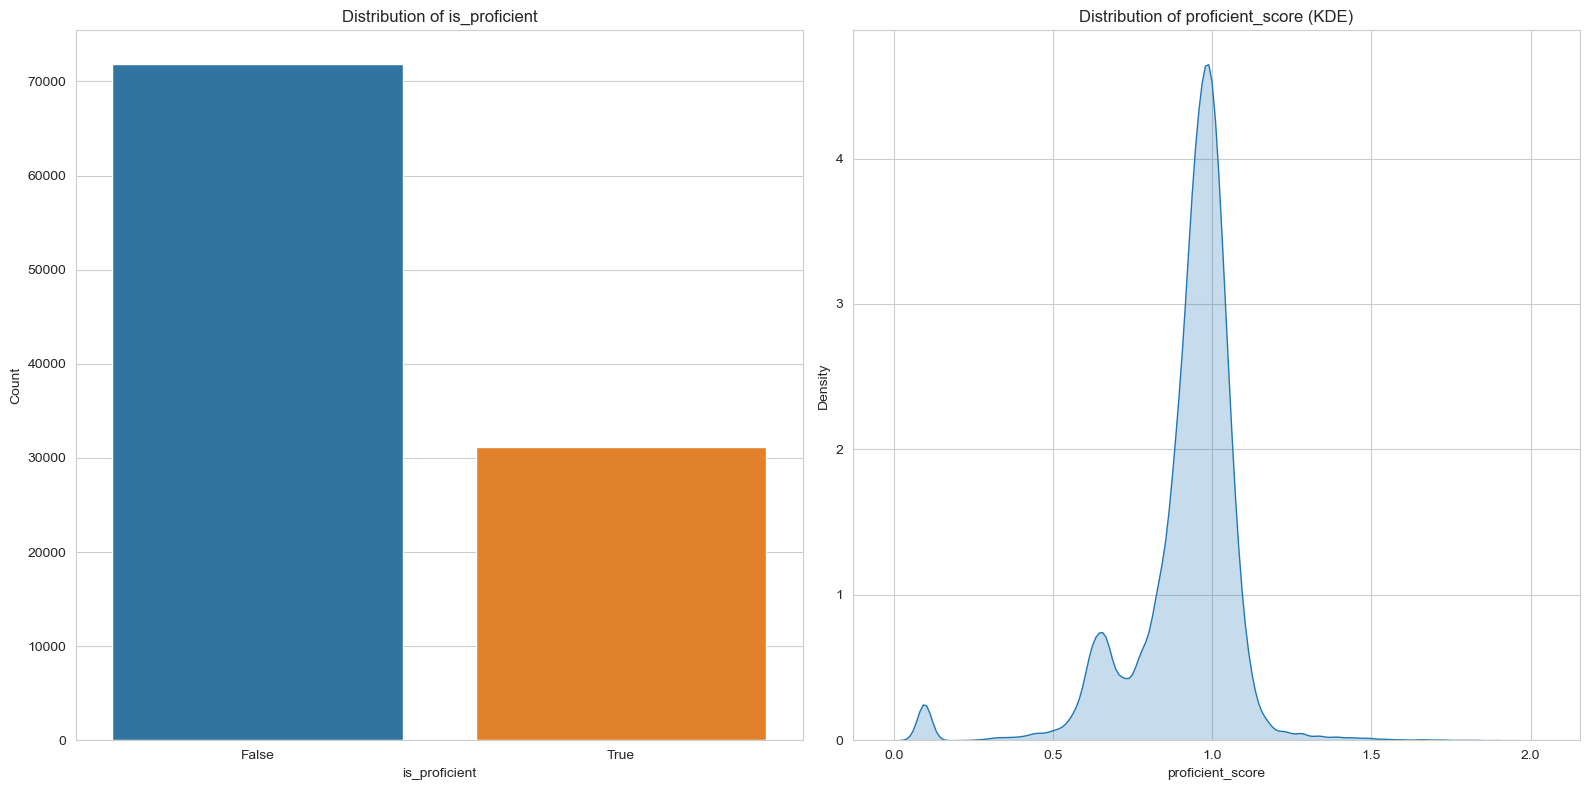


Overall Proficiency Rate: 30.27%


In [17]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16, 8))

# Plot distribution of is_proficient
sns.countplot(x='is_proficient', data=proficiency_melted_df, ax=ax1)
ax1.set_title('Distribution of is_proficient')
ax1.set_xlabel('is_proficient')
ax1.set_ylabel('Count')

# Plot distribution of proficient_score with KDE
sns.kdeplot(data=proficiency_melted_df['proficient_score'].dropna(), shade=True, ax=ax2)
ax2.set_title('Distribution of proficient_score (KDE)')
ax2.set_xlabel('proficient_score')
ax2.set_ylabel('Density')

# Plot distribution of proficient_score with KDE
# sns.kdeplot(data=proficiency_melted_df['proficient_diff'].dropna(), shade=True, ax=ax3)
# ax3.set_title('Distribution of proficient_diff (KDE)')
# ax3.set_xlabel('proficient_diff')
# ax3.set_ylabel('Density')

plt.tight_layout()
plt.show()

# Print proficiency rate
proficiency_rate = proficiency_melted_df['is_proficient'].mean() * 100
print(f"\nOverall Proficiency Rate: {proficiency_rate:.2f}%")

In [18]:
# Step 8: Pivot the result back to wide format
proficiency_df = proficiency_melted_df.pivot_table(
    index=['studentId', 'level', 'year'],
    columns='dataSource',
    values='is_proficient'
)

# Reset the index to make 'studentId', 'level', and 'year' regular columns
proficiency_df.reset_index(inplace=True)

# Rename columns to indicate they are proficiency indicators
proficiency_df.rename(
    columns=lambda x: f'proficient_{x}' if x not in ['studentId', 'level', 'year'] else x,
    inplace=True
)

# Merge the proficiency indicators back with the original scores_df
proficiency_df = pd.merge(scores_averaged_df, proficiency_df, 
                    left_on=['studentId', 'studentLevel', 'year'],
                    right_on=['studentId', 'level', 'year'],
                    how='left')

# Remove the redundant 'level' column from the merge
proficiency_df.drop('level', axis=1, inplace=True)

# Display the first few rows of the resulting DataFrame
proficiency_df.head()

,studentId,studentLevel,year,subgroup_specialEd,subgroup_lunchStatus,subgroup_gender,subgroup_ethnicity,subgroup_ell,subgroup_bottom25,value_actMathScore,value_actEnglishScore,value_actReadingScore,value_actScienceScore,value_actCompositeScore,value_nweaMath,value_nweaReading,value_nweaEnglish,value_iReadyMath,value_iReadyReading,value_actMasteryComposite,value_actMasteryReading,value_actMasteryMath,value_actMasteryScience,value_actMasteryEnglish,value_nweaELA,value_scantronMath,value_scantronReading,value_mapMath,value_mapEnglish,value_mapReading,value_mapRLA,value_scantronScience,value_scantronLanguage,value_ReadingFoundations,value_scantronAlgebra,value_eocMath,value_actELAScore,value_mapScience,value_LeapELAScale,value_LeapMathScale,value_LeapALScale,value_LeapE2Scale,value_LeapGmScale,value_LeapBlScale,value_LeapE3Scale,value_LeapUsScale,value_E1Scale,value_UsEsScale,value_accessReadingScale,value_accessReadingProficiency,value_accessCompositeScale,value_accesscompositeProficiency,value_dibelsReading,value_mapHistory,value_LEAPSocSci,value_scantronGeometry,value_MathMilestones,value_ELAMilestones,value_starReading,value_starMath,value_ScienceMilestones,value_LEAPScience,value_SocialMilestones,value_gcaInfo,value_gcaNar,value_gcaOpin,value_aimsWebMath,value_aimsWebReading,proficient_value_actCompositeScore,proficient_value_actEnglishScore,proficient_value_actMathScore,proficient_value_actReadingScore,proficient_value_actScienceScore,proficient_value_scantronMath,proficient_value_scantronReading,proficient_value_starMath
0,44774,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2824.5,2943.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN
1,44774,9,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44775,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2642.5,2665.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
3,44775,9,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,44776,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2264.0,2320.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [19]:
proficiency_melted_df['dataSource'].value_counts()


value_scantronMath         44232
value_scantronReading      44119
value_starMath              6484
value_actCompositeScore     3346
value_actMathScore          1206
value_actEnglishScore       1206
value_actScienceScore       1206
value_actReadingScore       1205
Name: dataSource, dtype: int64

# act*_11
Creates four dataframes: `actMath_11_df`, `actReading_11_df`, `actScience_11_df`, `actEnglish_11_df`

In [20]:
act_11_df = proficiency_melted_df[proficiency_melted_df['level'] == 11]
act_11_df = act_11_df[act_11_df['year'] == 2018]

# Merge subgroup columns from scores_df into act_11_df
subgroup_columns = ['subgroup_specialEd', 'subgroup_lunchStatus', 'subgroup_gender', 'subgroup_ethnicity', 'subgroup_ell', 'subgroup_bottom25']
act_11_df = act_11_df.merge(scores_df[['studentId'] + subgroup_columns], on='studentId', how='left')

act_11_df.head()

,studentId,level,year,dataSource,score,value,is_proficient,proficient_score,subgroup_specialEd,subgroup_lunchStatus,subgroup_gender,subgroup_ethnicity,subgroup_ell,subgroup_bottom25
0,45054,11,2018,value_actMathScore,4.5,17.0,False,0.264706,0,0,0,0,0,0
1,45054,11,2018,value_actMathScore,4.5,17.0,False,0.264706,0,0,0,0,0,0
2,45440,11,2018,value_actMathScore,16.0,17.0,False,0.941176,0,0,0,0,0,0
3,45440,11,2018,value_actMathScore,16.0,17.0,False,0.941176,0,0,0,0,0,0
4,45440,11,2018,value_actMathScore,16.0,17.0,False,0.941176,0,0,0,0,0,0


Dropped subgroups columns after plotting distributions.

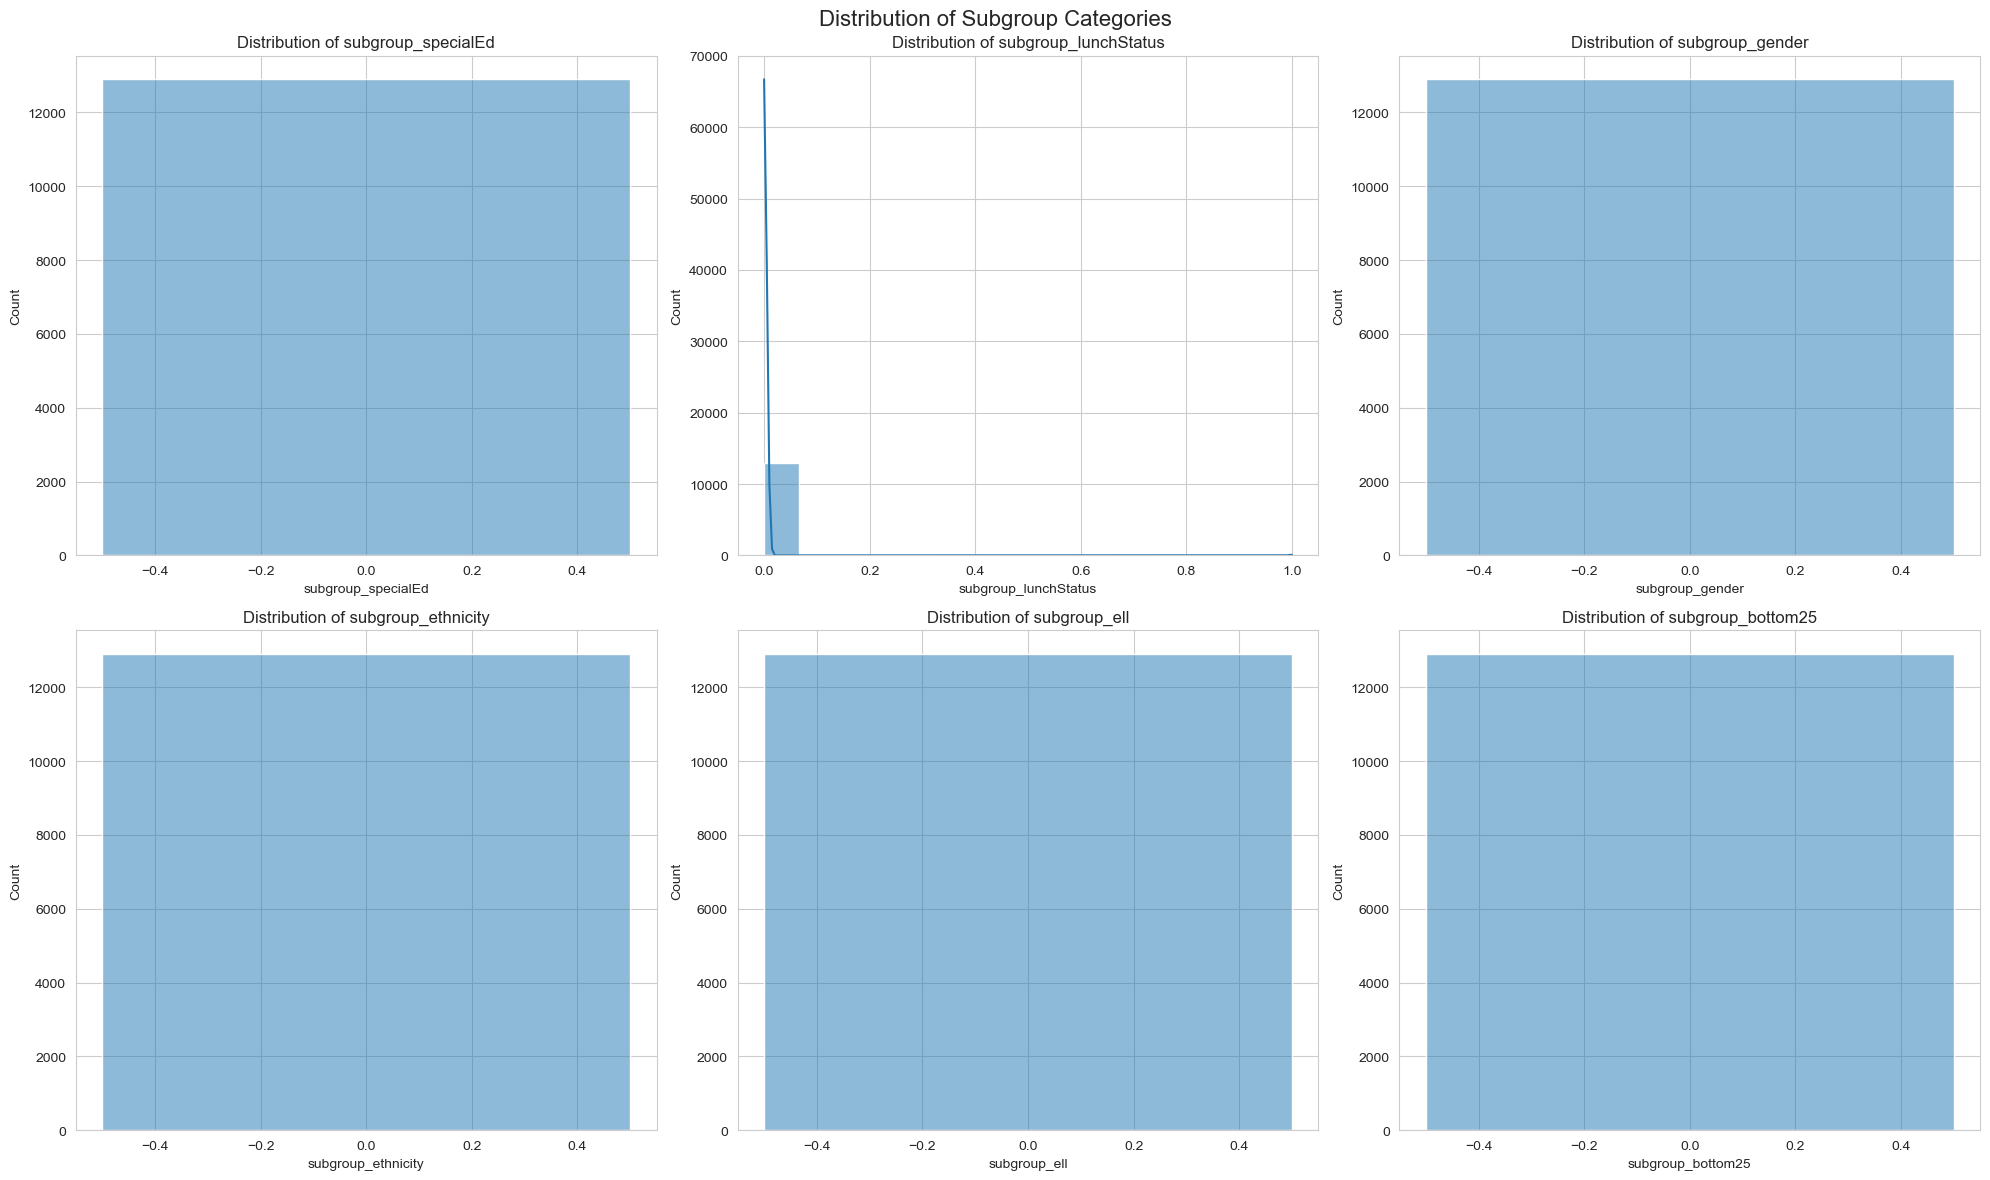


Value counts for subgroup_specialEd:
0    12896
Name: subgroup_specialEd, dtype: int64

--------------------------------------------------

Value counts for subgroup_lunchStatus:
0    12881
1       15
Name: subgroup_lunchStatus, dtype: int64

--------------------------------------------------

Value counts for subgroup_gender:
0    12896
Name: subgroup_gender, dtype: int64

--------------------------------------------------

Value counts for subgroup_ethnicity:
0    12896
Name: subgroup_ethnicity, dtype: int64

--------------------------------------------------

Value counts for subgroup_ell:
0    12896
Name: subgroup_ell, dtype: int64

--------------------------------------------------

Value counts for subgroup_bottom25:
0    12896
Name: subgroup_bottom25, dtype: int64

--------------------------------------------------


In [21]:
# Define the subgroup columns
subgroups = ['subgroup_specialEd', 'subgroup_lunchStatus', 'subgroup_gender', 
                    'subgroup_ethnicity', 'subgroup_ell', 'subgroup_bottom25']

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Distribution of Subgroup Categories', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot histograms for each subgroup
for i, column in enumerate(subgroups):
    sns.histplot(data=act_11_df, x=column, ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print value counts for each subgroup
for column in subgroups:
    print(f"\nValue counts for {column}:")
    print(act_11_df[column].value_counts(dropna=False))
    print("\n" + "-"*50)


In [22]:
act_11_df.drop(columns=subgroups, inplace=True)

Merge with courses taken by same students in previous year (2017, grade 10).

In [23]:
courses_act_df = courses[(courses['year'] == 2017) & (courses['studentLevel'] == 10)]
courses_act_df = courses_act_df.reset_index(drop=True)

In [24]:
courses_act_df.head()

,courseSectionId,studentId,studentLevel,vanityId,year,schoolId
0,73319,46413,10,W H 1500-P,2017,224
1,73320,47091,10,Biology,2017,224
2,73321,46413,10,Enviro Sci,2017,224
3,73322,46705,10,Enviro Sci,2017,224
4,73327,50738,10,LIFE PE 9-12,2017,224


In [25]:
act_11_courses = act_11_df.merge(courses_act_df[['vanityId', 'schoolId', 'studentId']], on='studentId', how='left')

# Create binary features for each unique course vanityId
course_dummies = pd.get_dummies(act_11_courses['vanityId'], prefix='course')

# Aggregate the binary features and schoolId by studentId
act_11_courses_grouped = pd.concat([course_dummies, act_11_courses[['studentId', 'schoolId']]], axis=1)
act_11_courses_grouped = act_11_courses_grouped.groupby('studentId').agg({
    **{col: 'max' for col in course_dummies.columns},
    'schoolId': 'first'  # Take the first non-null schoolId for each student
})

# Merge the binary course features and schoolId back to act_11_df
act_11_df = act_11_df.merge(act_11_courses_grouped, on='studentId', how='left')

# Fill NaN values with 0 for course features (students not enrolled in a course)
course_columns = [col for col in act_11_df.columns if col.startswith('course_')]
act_11_df[course_columns] = act_11_df[course_columns].fillna(0)

# Merge act_11_df with schools_df to get school names
act_11_df = act_11_df.merge(schools_df[['id', 'name']], left_on='schoolId', right_on='id', how='left')

# Rename the 'name' column to 'school'
act_11_df = act_11_df.rename(columns={'name': 'school'})

# Drop the 'id' and 'schoolId' columns
act_11_df = act_11_df.drop(['id', 'schoolId'], axis=1)

In [26]:
act_11_df.head()

,studentId,level,year,dataSource,score,value,is_proficient,proficient_score,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_USHis 1877-P,course_USHis I Adv,course_USHis I G10,course_USHis InD-P,course_USHisIG10ACC,course_VarBkbalI,course_VarBkbalII,course_VarBsbalI,course_VarBsbalII,course_VarBsblIV,course_VarCheerII,c

Merge with schools.

In [27]:
school_dummies = pd.get_dummies(act_11_df['school'], prefix='school')
act_11_df = pd.concat([act_11_df, school_dummies], axis=1)

# Drop the original 'school' column
act_11_df = act_11_df.drop('school', axis=1)

In [28]:
act_11_df = act_11_df[act_11_df['score'] != 0]

In [29]:
act_11_df.head()

,studentId,level,year,dataSource,score,value,is_proficient,proficient_score,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_USHis 1877-P,course_USHis I Adv,course_USHis I G10,course_USHis InD-P,course_USHisIG10ACC,course_VarBkbalI,course_VarBkbalII,course_VarBsbalI,course_VarBsbalII,course_VarBsblIV,course_VarCheerII,c

Merge in vendorUsage.

In [30]:
vendorUsage_2017_df = vendorUsage_df[vendorUsage_df['year'] == 2017]
vendorUsage_2017_df.drop(columns=['year'], inplace=True)
vendorUsage_2017_df.reset_index(drop=True, inplace=True)
vendorUsage_2017_df.head()

C:\Users\lmmag\AppData\Local\Temp\ipykernel_53284\3338933051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vendorUsage_2017_df.drop(columns=['year'], inplace=True)


,studentId,iready_math,iready_reading,bbb_literacy
0,119353,2,2,0
1,119371,2,2,0
2,119372,2,2,0
3,119373,2,2,0
4,119413,0,2,0


In [31]:
act_11_df = act_11_df.merge(vendorUsage_2017_df, on='studentId', how='left')
act_11_df = act_11_df.fillna(0)
to_int = ['iready_math', 'iready_reading', 'bbb_literacy']
for col in to_int:
    act_11_df[col] = act_11_df[col].astype(int)
act_11_df.head()

,studentId,level,year,dataSource,score,value,is_proficient,proficient_score,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_USHis 1877-P,course_USHis I Adv,course_USHis I G10,course_USHis InD-P,course_USHisIG10ACC,course_VarBkbalI,course_VarBkbalII,course_VarBsbalI,course_VarBsbalII,course_VarBsblIV,course_VarCheerII,c

Split into subject scores.

In [32]:
act_11_df['dataSource'].value_counts()

value_actMathScore         2580
value_actEnglishScore      2580
value_actScienceScore      2580
value_actReadingScore      2578
value_actCompositeScore    2578
Name: dataSource, dtype: int64

In [33]:
# Drop level, year, (same for all rows) and score, value (captured in label)
columns_to_drop = ['level', 'year', 'score', 'value']
act_11_df.drop(columns=[col for col in columns_to_drop if col in act_11_df.columns], inplace=True)

In [34]:
actMath_11_df = act_11_df[act_11_df['dataSource'] == 'value_actMathScore']
actReading_11_df = act_11_df[act_11_df['dataSource'] == 'value_actReadingScore']
actScience_11_df = act_11_df[act_11_df['dataSource'] == 'value_actScienceScore']
actEnglish_11_df = act_11_df[act_11_df['dataSource'] == 'value_actEnglishScore']

In [35]:
for subject in ['Math', 'Reading', 'Science', 'English']:
    df_name = f'act{subject}_11_df'
    df = locals()[df_name]
    new_df = df.drop(columns=['dataSource'])
    locals()[df_name] = new_df


actMath_11_df.to_csv('dataframes/actMath_11.csv', index=False)
actReading_11_df.to_csv('dataframes/actReading_11.csv', index=False)
actScience_11_df.to_csv('dataframes/actScience_11.csv', index=False)
actEnglish_11_df.to_csv('dataframes/actEnglish_11.csv', index=False)

# scantron*_38
Creates two dataframes: `scantronMath_38_df` and `scantronReading_38_df`.

In [36]:
proficiency_melted_df[proficiency_melted_df['studentId'] == 44777]

,studentId,level,year,dataSource,score,value,is_proficient,proficient_score
80614,44777,6,2017,value_scantronMath,2562.000000,2675.0,False,0.957757
80615,44777,7,2018,value_scantronMath,2565.666667,2743.0,False,0.935351
134335,44777,6,2017,value_scantronReading,2808.000000,2897.0,False,0.969279
134336,44777,7,2018,value_scantronReading,2934.333333,2954.0,False,0.993342
439157,44777,7,2018,value_starMath,1657.333333,2743.0,False,0.604205


In [37]:
scantron_38_df = proficiency_melted_df[(proficiency_melted_df['level'] >= 3) & (proficiency_melted_df['level'] <= 8)]
scantron_38_df = scantron_38_df[scantron_38_df['year'] == 2018]

# Merge subgroup columns from scores_df into scantron_38_df
subgroup_cols = ['subgroup_specialEd', 'subgroup_lunchStatus', 'subgroup_gender', 'subgroup_ethnicity', 'subgroup_ell', 'subgroup_bottom25']
scores_subgroups = scores_averaged_df[['studentId'] + subgroup_cols].drop_duplicates('studentId')

scantron_38_df = scantron_38_df.merge(scores_subgroups, on='studentId', how='left')

scantron_38_df.head()
scantron_38_df[scantron_38_df['studentId'] == 44777]

,studentId,level,year,dataSource,score,value,is_proficient,proficient_score,subgroup_specialEd,subgroup_lunchStatus,subgroup_gender,subgroup_ethnicity,subgroup_ell,subgroup_bottom25
0,44777,7,2018,value_scantronMath,2565.666667,2743.0,False,0.935351,0.0,0.0,0.0,0.0,0.0,1.0
20570,44777,7,2018,value_scantronReading,2934.333333,2954.0,False,0.993342,0.0,0.0,0.0,0.0,0.0,1.0
41029,44777,7,2018,value_starMath,1657.333333,2743.0,False,0.604205,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
scantron_38_df.shape

(47513, 14)

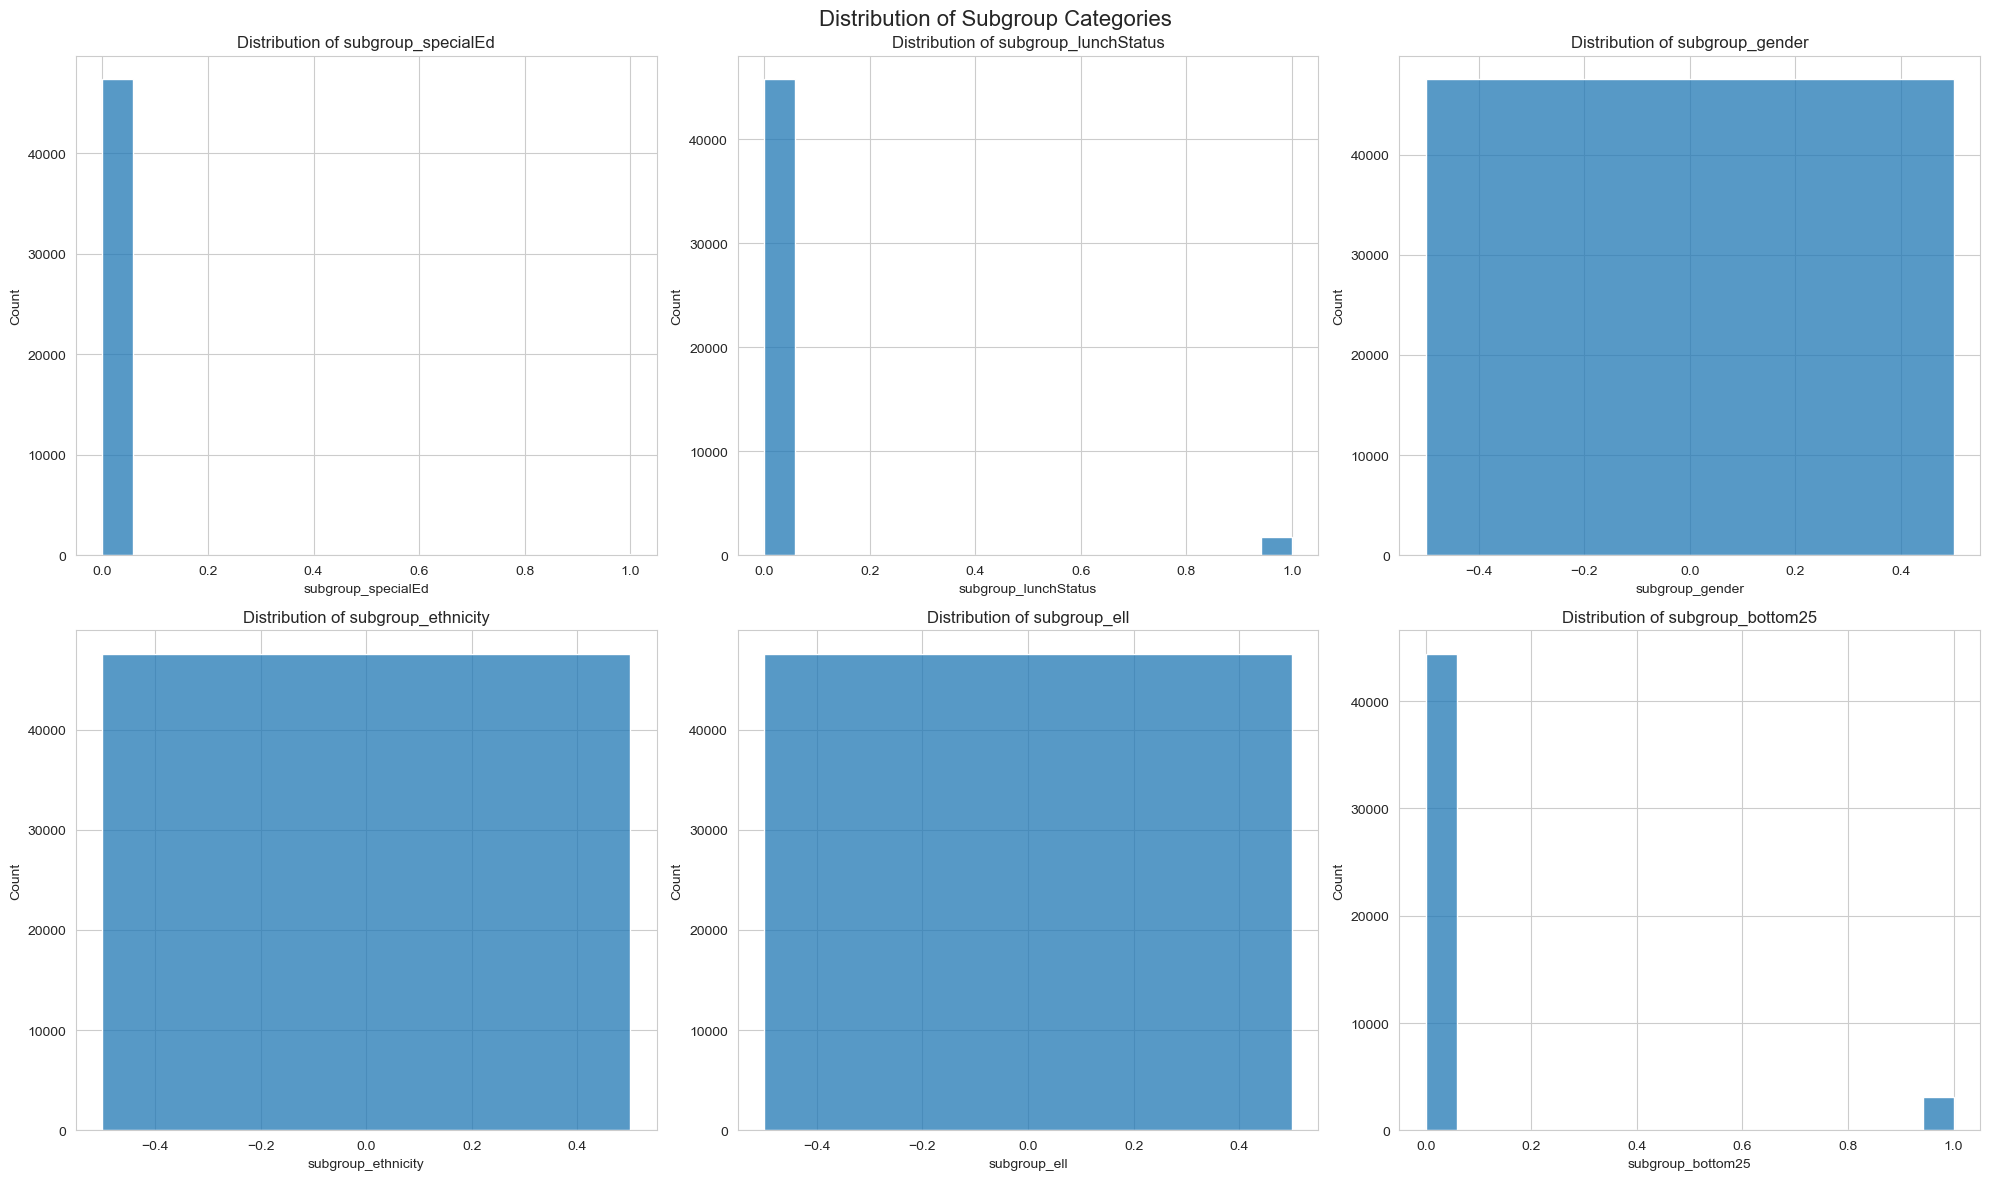


Value counts for subgroup_specialEd:
0.0    47357
1.0      156
Name: subgroup_specialEd, dtype: int64

--------------------------------------------------

Value counts for subgroup_lunchStatus:
0.0    45768
1.0     1745
Name: subgroup_lunchStatus, dtype: int64

--------------------------------------------------

Value counts for subgroup_gender:
0.0    47513
Name: subgroup_gender, dtype: int64

--------------------------------------------------

Value counts for subgroup_ethnicity:
0.0    47513
Name: subgroup_ethnicity, dtype: int64

--------------------------------------------------

Value counts for subgroup_ell:
0.0    47513
Name: subgroup_ell, dtype: int64

--------------------------------------------------

Value counts for subgroup_bottom25:
0.0    44371
1.0     3142
Name: subgroup_bottom25, dtype: int64

--------------------------------------------------


In [39]:
# Define the subgroup columns
subgroups = ['subgroup_specialEd', 'subgroup_lunchStatus', 'subgroup_gender', 
                    'subgroup_ethnicity', 'subgroup_ell', 'subgroup_bottom25']

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Distribution of Subgroup Categories', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot histograms for each subgroup
for i, column in enumerate(subgroups):
    sns.histplot(data=scantron_38_df, x=column, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print value counts for each subgroup
for column in subgroups:
    print(f"\nValue counts for {column}:")
    print(scantron_38_df[column].value_counts(dropna=False))
    print("\n" + "-"*50)

In [40]:
scantron_38_df.drop(columns=subgroups, inplace=True)
scantron_38_df.head()

,studentId,level,year,dataSource,score,value,is_proficient,proficient_score
0,44777,7,2018,value_scantronMath,2565.666667,2743.0,False,0.935351
1,44783,7,2018,value_scantronMath,2673.666667,2743.0,False,0.974724
2,44784,6,2018,value_scantronMath,2724.666667,2667.0,True,1.021622
3,44807,7,2018,value_scantronMath,2784.666667,2743.0,True,1.015190
4,44809,7,2018,value_scantronMath,2528.333333,2743.0,False,0.921740


Merge with courses taken by same students in previous year (2017, grades 3-8).

In [41]:
courses_scantron_df = courses[(courses['year'] == 2017) & (courses['studentLevel'].between(3, 8))]
courses_scantron_df = courses_scantron_df.reset_index(drop=True)

In [42]:
courses_scantron_df.head()

,courseSectionId,studentId,studentLevel,vanityId,year,schoolId
0,72510,68527,4,SCIENCE 4,2017,232
1,72510,54855,4,SCIENCE 4,2017,232
2,72510,54759,4,SCIENCE 4,2017,232
3,72510,52209,4,SCIENCE 4,2017,232
4,72510,52197,4,SCIENCE 4,2017,232


In [43]:
scantron_38_courses = scantron_38_df.merge(courses_scantron_df[['vanityId', 'schoolId', 'studentId']], on='studentId', how='left')

# Create binary features for each unique course vanityId
course_dummies = pd.get_dummies(scantron_38_courses['vanityId'], prefix='course')

# Aggregate the binary features and schoolId by studentId
scantron_38_courses_grouped = pd.concat([course_dummies, scantron_38_courses[['studentId', 'schoolId']]], axis=1)
scantron_38_courses_grouped = scantron_38_courses_grouped.groupby('studentId').agg({
    **{col: 'max' for col in course_dummies.columns},
    'schoolId': 'first'  # Take the first non-null schoolId for each student
})

# Merge the binary course features and schoolId back to scantron_38_df
scantron_38_df = scantron_38_df.merge(scantron_38_courses_grouped, on='studentId', how='left')

# Fill NaN values with 0 for course features (students not enrolled in a course)
course_columns = [col for col in scantron_38_df.columns if col.startswith('course_')]
scantron_38_df[course_columns] = scantron_38_df[course_columns].fillna(0)

# Merge scantron_38_df with schools_df to get school names
scantron_38_df = scantron_38_df.merge(schools_df[['id', 'name']], left_on='schoolId', right_on='id', how='left')

# Rename the 'name' column to 'school'
scantron_38_df = scantron_38_df.rename(columns={'name': 'school'})

# Drop the 'id' and 'schoolId' columns
scantron_38_df = scantron_38_df.drop(['id', 'schoolId'], axis=1)

In [44]:
scantron_38_df.head()

,studentId,level,year,dataSource,score,value,is_proficient,proficient_score,course_AIDELIB7-8NC,course_AIDSTU6-12NC,course_ARTHIS7-8,course_Advisory 5,course_Advisory 6,course_Advisory 7,course_Advisory 7-8,course_Advisory 8,course_Aide Off 7-8,course_BAND 6,course_BAND 7 Brass,course_BAND 7 Percu,course_BAND 7 Wood,course_BROADCAS 7-8,course_Band 7,course_Band7,course_BandGuitar78,course_CONTISSU 7-8,course_CREAWRT 7-8,course_CSElec Gr7-8,course_CareerPrep-A,course_CareerPrepA5,course_CivicH/Adv 7,course_CivicsGr 7,course_ContIssu 7-8,course_Drama 7-8,course_ELA IntPK-6,course_ELAGrPK5H/Ad,course_ELAGrPK6H/Ad,course_ENRICELA78,course_ENRICMATH78,course_ESLENRICH6-8,course_ESLEnrich6-8,course_Eng 7 H/Adv,course_EngElec7-8,course_EngIntrv7-12,course_EngLang6,course_English Gr 7,course_English Gr 8,course_English LA 5,course_English LA 6,course_EnricMath78,course_EnrichmtP6,course_Extrcur6-12C,course_ForSci7-8,course_Geog Gr7,course_GeogH/AdvGr7,course_Gifted,course_Gifted 5,course_HANDWRITING,course_HOMEROOM,course_HWK-4,course_Handwriting,course_LANGUAGE 3,course_LANGUAGE 4,course_LifeSci Gr7,course_LifeSciH Gr7,course_MATH,course_MATH 3,course_MATH 4,course_MATH 5,course_MATH 6,course_MATH 7,course_Marketing,course_Math 7,course_Math 7 H/A,course_Math 8,"course_Math,Grade 5",course_Math5H/Adv,course_Math6H/Adv,course_Math8 PreAlg,course_MthCooking,course_MthIntrv7-12,course_Music Grade5,course_Music Grade6,course_MusicApp 7,course_OLDigitalCit,course_PE 3,course_PE 4,course_PE 5,course_PE 6,course_PE 7,course_PE 7 Girls,course_PE 7-8,course_PE 8,course_PhySci Gr 8,course_Phys Ed Gr 5,course_Phys Ed Gr 6,course_PhysEd Gr7-8,course_READ 3,course_READING 3,course_READING 4,course_Reading.BS 7,course_SCIENCE 3,course_SCIENCE 4,course_SCIENCE 5,course_SCIENCE 6,course_SCIENCE LI 7,course_SOC ST 3,course_SOC ST 4,course_SOC ST 5,course_SOC ST 6,course_ScElecGr7-8,course_SciG5H/A,course_SciGr6H/A,course_Science Gr 5,course_Science Gr 6,course_SoDevSk6-12C,course_SoSt5H/A,course_SoSt6H/A,course_SocStudies 6,course_SocialStuGr5,course_SocialStuGr6,course_Sp&Lang Imp,course_SpanishExp 7,course_StuAid6-12NC,course_StuAide7-8NC,course_StuHall6-12,course_StuHallPK6,course_Survey Elec7,course_Survey Elec8,course_Tech Ed 7-8,course_WLDHIS 1500,course_Yearbook 7-8,school
0,44777,7,2018,value_scantronMath,2565.666667,2743.0,False,0.935351,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,Middle School A
1,44783,7,2018,value_scantronMath,2673.666667,2743.0,False,0.974724,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Middle School A
2,44784,6,2018,value_scantronMath,2724.666667,2667.0,True,1.021622,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Middle School A
3,44807,7,2018,value_scantronMath,2784.666667,2743.0,True,1.015190,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Middle School A
4,44809,7,2018,value_scantronMath,2528.333333,2743.0,False,0.921740,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Middle School A


Merge with schools.

In [45]:
school_dummies = pd.get_dummies(scantron_38_df['school'], prefix='school')
scantron_38_df = pd.concat([scantron_38_df, school_dummies], axis=1)

# Drop the original 'school' column
scantron_38_df = scantron_38_df.drop('school', axis=1)

In [46]:
scantron_38_df = scantron_38_df[scantron_38_df['score'] != 0]

In [47]:
scantron_38_df.head()

,studentId,level,year,dataSource,score,value,is_proficient,proficient_score,course_AIDELIB7-8NC,course_AIDSTU6-12NC,course_ARTHIS7-8,course_Advisory 5,course_Advisory 6,course_Advisory 7,course_Advisory 7-8,course_Advisory 8,course_Aide Off 7-8,course_BAND 6,course_BAND 7 Brass,course_BAND 7 Percu,course_BAND 7 Wood,course_BROADCAS 7-8,course_Band 7,course_Band7,course_BandGuitar78,course_CONTISSU 7-8,course_CREAWRT 7-8,course_CSElec Gr7-8,course_CareerPrep-A,course_CareerPrepA5,course_CivicH/Adv 7,course_CivicsGr 7,course_ContIssu 7-8,course_Drama 7-8,course_ELA IntPK-6,course_ELAGrPK5H/Ad,course_ELAGrPK6H/Ad,course_ENRICELA78,course_ENRICMATH78,course_ESLENRICH6-8,course_ESLEnrich6-8,course_Eng 7 H/Adv,course_EngElec7-8,course_EngIntrv7-12,course_EngLang6,course_English Gr 7,course_English Gr 8,course_English LA 5,course_English LA 6,course_EnricMath78,course_EnrichmtP6,course_Extrcur6-12C,course_ForSci7-8,course_Geog Gr7,course_GeogH/AdvGr7,course_Gifted,course_Gifted 5,course_HANDWRITING,course_HOMEROOM,course_HWK-4,course_Handwriting,course_LANGUAGE 3,course_LANGUAGE 4,course_LifeSci Gr7,course_LifeSciH Gr7,course_MATH,course_MATH 3,course_MATH 4,course_MATH 5,course_MATH 6,course_MATH 7,course_Marketing,course_Math 7,course_Math 7 H/A,course_Math 8,"course_Math,Grade 5",course_Math5H/Adv,course_Math6H/Adv,course_Math8 PreAlg,course_MthCooking,course_MthIntrv7-12,course_Music Grade5,course_Music Grade6,course_MusicApp 7,course_OLDigitalCit,course_PE 3,course_PE 4,course_PE 5,course_PE 6,course_PE 7,course_PE 7 Girls,course_PE 7-8,course_PE 8,course_PhySci Gr 8,course_Phys Ed Gr 5,course_Phys Ed Gr 6,course_PhysEd Gr7-8,course_READ 3,course_READING 3,course_READING 4,course_Reading.BS 7,course_SCIENCE 3,course_SCIENCE 4,course_SCIENCE 5,course_SCIENCE 6,course_SCIENCE LI 7,course_SOC ST 3,course_SOC ST 4,course_SOC ST 5,course_SOC ST 6,course_ScElecGr7-8,course_SciG5H/A,course_SciGr6H/A,course_Science Gr 5,course_Science Gr 6,course_SoDevSk6-12C,course_SoSt5H/A,course_SoSt6H/A,course_SocStudies 6,course_SocialStuGr5,course_SocialStuGr6,course_Sp&Lang Imp,course_SpanishExp 7,course_StuAid6-12NC,course_StuAide7-8NC,course_StuHall6-12,course_StuHallPK6,course_Survey Elec7,course_Survey Elec8,course_Tech Ed 7-8,course_WLDHIS 1500,course_Yearbook 7-8,school_Elementary A,school_Elementary School B,school_Elementary School E,school_Elementary School F,school_Intermediate School E,school_Middle School A,school_Middle School C,school_Middle School D,school_Middle School F
0,44777,7,2018,value_scantronMath,2565.666667,2743.0,False,0.935351,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,44783,7,2018,value_scantronMath,2673.666667,2743.0,False,0.974724,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,44784,6,2018,value_scantronMath,2724.666667,2667.0,True,1.021622,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,44807,7,2018,value_scantronMath,2784.666667,2743.0,True,1.015190,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,44809,7,2018,value_scantronMath,2528.333333,2743.0,False,0.921740,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,

Merge in vendorUsage.

In [48]:
vendorUsage_2017_df = vendorUsage_df[vendorUsage_df['year'] == 2017].copy()
vendorUsage_2017_df.drop(columns=['year'], inplace=True)
vendorUsage_2017_df.reset_index(drop=True, inplace=True)
vendorUsage_2017_df.head()

,studentId,iready_math,iready_reading,bbb_literacy
0,119353,2,2,0
1,119371,2,2,0
2,119372,2,2,0
3,119373,2,2,0
4,119413,0,2,0


In [49]:
scantron_38_df = scantron_38_df.merge(vendorUsage_2017_df, on='studentId', how='left')
scantron_38_df = scantron_38_df.fillna(0)
to_int = ['iready_math', 'iready_reading', 'bbb_literacy']
for col in to_int:
    scantron_38_df[col] = scantron_38_df[col].astype(int)

In [50]:
scantron_38_df.head()

,studentId,level,year,dataSource,score,value,is_proficient,proficient_score,course_AIDELIB7-8NC,course_AIDSTU6-12NC,course_ARTHIS7-8,course_Advisory 5,course_Advisory 6,course_Advisory 7,course_Advisory 7-8,course_Advisory 8,course_Aide Off 7-8,course_BAND 6,course_BAND 7 Brass,course_BAND 7 Percu,course_BAND 7 Wood,course_BROADCAS 7-8,course_Band 7,course_Band7,course_BandGuitar78,course_CONTISSU 7-8,course_CREAWRT 7-8,course_CSElec Gr7-8,course_CareerPrep-A,course_CareerPrepA5,course_CivicH/Adv 7,course_CivicsGr 7,course_ContIssu 7-8,course_Drama 7-8,course_ELA IntPK-6,course_ELAGrPK5H/Ad,course_ELAGrPK6H/Ad,course_ENRICELA78,course_ENRICMATH78,course_ESLENRICH6-8,course_ESLEnrich6-8,course_Eng 7 H/Adv,course_EngElec7-8,course_EngIntrv7-12,course_EngLang6,course_English Gr 7,course_English Gr 8,course_English LA 5,course_English LA 6,course_EnricMath78,course_EnrichmtP6,course_Extrcur6-12C,course_ForSci7-8,course_Geog Gr7,course_GeogH/AdvGr7,course_Gifted,course_Gifted 5,course_HANDWRITING,course_HOMEROOM,course_HWK-4,course_Handwriting,course_LANGUAGE 3,course_LANGUAGE 4,course_LifeSci Gr7,course_LifeSciH Gr7,course_MATH,course_MATH 3,course_MATH 4,course_MATH 5,course_MATH 6,course_MATH 7,course_Marketing,course_Math 7,course_Math 7 H/A,course_Math 8,"course_Math,Grade 5",course_Math5H/Adv,course_Math6H/Adv,course_Math8 PreAlg,course_MthCooking,course_MthIntrv7-12,course_Music Grade5,course_Music Grade6,course_MusicApp 7,course_OLDigitalCit,course_PE 3,course_PE 4,course_PE 5,course_PE 6,course_PE 7,course_PE 7 Girls,course_PE 7-8,course_PE 8,course_PhySci Gr 8,course_Phys Ed Gr 5,course_Phys Ed Gr 6,course_PhysEd Gr7-8,course_READ 3,course_READING 3,course_READING 4,course_Reading.BS 7,course_SCIENCE 3,course_SCIENCE 4,course_SCIENCE 5,course_SCIENCE 6,course_SCIENCE LI 7,course_SOC ST 3,course_SOC ST 4,course_SOC ST 5,course_SOC ST 6,course_ScElecGr7-8,course_SciG5H/A,course_SciGr6H/A,course_Science Gr 5,course_Science Gr 6,course_SoDevSk6-12C,course_SoSt5H/A,course_SoSt6H/A,course_SocStudies 6,course_SocialStuGr5,course_SocialStuGr6,course_Sp&Lang Imp,course_SpanishExp 7,course_StuAid6-12NC,course_StuAide7-8NC,course_StuHall6-12,course_StuHallPK6,course_Survey Elec7,course_Survey Elec8,course_Tech Ed 7-8,course_WLDHIS 1500,course_Yearbook 7-8,school_Elementary A,school_Elementary School B,school_Elementary School E,school_Elementary School F,school_Intermediate School E,school_Middle School A,school_Middle School C,school_Middle School D,school_Middle School F,iready_math,iready_reading,bbb_literacy
0,44777,7,2018,value_scantronMath,2565.666667,2743.0,False,0.935351,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,44783,7,2018,value_scantronMath,2673.666667,2743.0,False,0.974724,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,44784,6,2018,value_scantronMath,2724.666667,2667.0,True,1.021622,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,44807,7,2018,value_scantronMath,2784.666667,2743.0,True,1.015190,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,44809,7,2018,value_scantronMath,2528.333333,2743.0,False,0.921740,0,0,0,0,1,0,0,0,0,0,0,

In [51]:
scantron_38_df.shape

(47513, 144)

Merge in past proficiency (just 2017).

In [52]:
past_proficiency = proficiency_melted_df[(proficiency_melted_df['year'] == 2017) & ((proficiency_melted_df['dataSource'] == 'value_scantronMath') | (proficiency_melted_df['dataSource'] == 'value_scantronReading'))]
past_proficiency.rename(columns={'is_proficient':'past_is_proficient', 'proficient_score': 'past_proficient_score'}, inplace=True)
past_proficiency.head()

C:\Users\lmmag\AppData\Local\Temp\ipykernel_53284\2422493654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_proficiency.rename(columns={'is_proficient':'past_is_proficient', 'proficient_score': 'past_proficient_score'}, inplace=True)


,studentId,level,year,dataSource,score,value,past_is_proficient,past_proficient_score
80611,44774,8,2017,value_scantronMath,2824.5,2823.0,True,1.000531
80612,44775,8,2017,value_scantronMath,2642.5,2823.0,False,0.936061
80613,44776,8,2017,value_scantronMath,2264.0,2823.0,False,0.801984
80614,44777,6,2017,value_scantronMath,2562.0,2675.0,False,0.957757
80616,44778,8,2017,value_scantronMath,2427.5,2823.0,False,0.859901


In [53]:
scantron_38_df = scantron_38_df.merge(past_proficiency[['studentId', 'dataSource', 'past_proficient_score']], on=['studentId', 'dataSource'], how='left')
scantron_38_df.head()

,studentId,level,year,dataSource,score,value,is_proficient,proficient_score,course_AIDELIB7-8NC,course_AIDSTU6-12NC,course_ARTHIS7-8,course_Advisory 5,course_Advisory 6,course_Advisory 7,course_Advisory 7-8,course_Advisory 8,course_Aide Off 7-8,course_BAND 6,course_BAND 7 Brass,course_BAND 7 Percu,course_BAND 7 Wood,course_BROADCAS 7-8,course_Band 7,course_Band7,course_BandGuitar78,course_CONTISSU 7-8,course_CREAWRT 7-8,course_CSElec Gr7-8,course_CareerPrep-A,course_CareerPrepA5,course_CivicH/Adv 7,course_CivicsGr 7,course_ContIssu 7-8,course_Drama 7-8,course_ELA IntPK-6,course_ELAGrPK5H/Ad,course_ELAGrPK6H/Ad,course_ENRICELA78,course_ENRICMATH78,course_ESLENRICH6-8,course_ESLEnrich6-8,course_Eng 7 H/Adv,course_EngElec7-8,course_EngIntrv7-12,course_EngLang6,course_English Gr 7,course_English Gr 8,course_English LA 5,course_English LA 6,course_EnricMath78,course_EnrichmtP6,course_Extrcur6-12C,course_ForSci7-8,course_Geog Gr7,course_GeogH/AdvGr7,course_Gifted,course_Gifted 5,course_HANDWRITING,course_HOMEROOM,course_HWK-4,course_Handwriting,course_LANGUAGE 3,course_LANGUAGE 4,course_LifeSci Gr7,course_LifeSciH Gr7,course_MATH,course_MATH 3,course_MATH 4,course_MATH 5,course_MATH 6,course_MATH 7,course_Marketing,course_Math 7,course_Math 7 H/A,course_Math 8,"course_Math,Grade 5",course_Math5H/Adv,course_Math6H/Adv,course_Math8 PreAlg,course_MthCooking,course_MthIntrv7-12,course_Music Grade5,course_Music Grade6,course_MusicApp 7,course_OLDigitalCit,course_PE 3,course_PE 4,course_PE 5,course_PE 6,course_PE 7,course_PE 7 Girls,course_PE 7-8,course_PE 8,course_PhySci Gr 8,course_Phys Ed Gr 5,course_Phys Ed Gr 6,course_PhysEd Gr7-8,course_READ 3,course_READING 3,course_READING 4,course_Reading.BS 7,course_SCIENCE 3,course_SCIENCE 4,course_SCIENCE 5,course_SCIENCE 6,course_SCIENCE LI 7,course_SOC ST 3,course_SOC ST 4,course_SOC ST 5,course_SOC ST 6,course_ScElecGr7-8,course_SciG5H/A,course_SciGr6H/A,course_Science Gr 5,course_Science Gr 6,course_SoDevSk6-12C,course_SoSt5H/A,course_SoSt6H/A,course_SocStudies 6,course_SocialStuGr5,course_SocialStuGr6,course_Sp&Lang Imp,course_SpanishExp 7,course_StuAid6-12NC,course_StuAide7-8NC,course_StuHall6-12,course_StuHallPK6,course_Survey Elec7,course_Survey Elec8,course_Tech Ed 7-8,course_WLDHIS 1500,course_Yearbook 7-8,school_Elementary A,school_Elementary School B,school_Elementary School E,school_Elementary School F,school_Intermediate School E,school_Middle School A,school_Middle School C,school_Middle School D,school_Middle School F,iready_math,iready_reading,bbb_literacy,past_proficient_score
0,44777,7,2018,value_scantronMath,2565.666667,2743.0,False,0.935351,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.957757
1,44783,7,2018,value_scantronMath,2673.666667,2743.0,False,0.974724,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.949346
2,44784,6,2018,value_scantronMath,2724.666667,2667.0,True,1.021622,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.990132
3,44807,7,2018,value_scantronMath,2784.666667,2743.0,True,1.015190,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.035514
4,44809,7,2018,value_scantronMat

Split into subject scores.

In [54]:
# Drop level, year, (same for all rows) and score, value (captured in label)
columns_to_drop = ['year', 'score', 'value']
scantron_38_df.drop(columns=[col for col in columns_to_drop if col in scantron_38_df.columns], inplace=True)

In [55]:
scantronMath_38_df = scantron_38_df[scantron_38_df['dataSource'] == 'value_scantronMath']
scantronReading_38_df = scantron_38_df[scantron_38_df['dataSource'] == 'value_scantronReading']

In [56]:
scantronMath_38_df.to_csv('dataframes/scantronMath_38.csv', index=False)
scantronReading_38_df.to_csv('dataframes/scantronReading_38.csv', index=False)

# Encode courses

## actMath_11

In [57]:
actMath_11_df = pd.read_csv('dataframes/actMath_11.csv')

In [58]:
actMath_11_course_list = [col for col in actMath_11_df.columns if col.startswith('course_')]

In [59]:
actMath_11_core_categories = {
    # Core Subjects RUN BY PRADNYA 
    "MATHEMATICS": {
        "regular": [
            "course_Alg Esntls B",
            "course_AlgEnrichmet",
            "course_Algebra I",
            "course_Algebra I A",
            "course_Algebra I B",
            "course_AlgebraicCon",
            "course_Geo Ess",
            "course_Algebra II",
            "course_Geometry",
            "course_ALG I B ACCE"
        ],
        "advanced": [
            "course_Alg II/Trig",
            "course_AlgII/TrigAC",
            "course_GEOM ADV",
            "course_Geometry Adv",
            "course_GeometryACCE"
        ]
    },
    
    "ENGLISH": {
        "regular": [
            "course_Eng Ess 10",
            "course_Eng Ess 11",
            "course_EngGr9-CR",
            "course_ESLEnrich912",
            "course_ESLLang9-12",
            "course_English Gr 9",
            "course_English Gr10",
            "course_English Gr11"
        ],
        "advanced": [
            "course_Eng Gr10 Adv",
            "course_EnglGr10ACCE",
            "course_Crea Writing",
            "course_CreatWrt.5C"
        ],
    },

    "SCIENCE": {
        "regular": [
            "course_Ess: Phy Sci",
            "course_EssPhySci",
            "course_PhySciACCESS",
            "course_Biology",
            "course_Chemistry",
            "course_Physical Sci"
        ],
        "advanced": [
            "course_BIOLOGY ADV",
            "course_Biology Adv",
            "course_ChemistryAdv",
            "course_Phy Sci Adv",
            "course_R/DinPhysics",
            "course_Anat/Physio",
            "course_Ear/SpaceSci",
            "course_Enviro Sci",
            "course_Marine Sci",
            "course_For/Cri Inve"
        ],
    },

    "SOCIAL_STUDIES": {
        "regular": [
            "course_US His-1877",
            "course_USHis 1877-P",
            "course_W H 1500-P",
            "course_WH 1500-P-CR",
            "course_Anthropology",
            "course_Psychology",
        ],
        "advanced": [
            "course_HISTUS1877AC",
            "course_HS US 10 ADV",
            "course_USHis I Adv",
            "course_WH1500-P Adv",
            "course_Psyc AP Acc",
            "course_Sociology",
            "course_SociologyACC",
            "course_ContempIss1C"
        ],
    },

    # Foreign Languages
    "FOREIGN_LANGUAGE": {
        "regular": [
            "course_SPANISH I",
            "course_Spanish 1",
            "course_SPANISH II",
            "course_Spanish 2",
            "course_Spanish 3"
        ],
        "advanced": [
            "course_SpanIACC",
            "course_SPAN II ACCE",
            "course_FrenchIACCE",
            "course_German1ACCES",
            "course_LATIN 1 ACC"
        ],
    },
}

actMath_11_other_categories = {
    # Fine Arts
    "PERFORMING_ARTS": {
        "course_BAND MARCH",
        "course_BANDCONCERT",
        "course_BANDMARCHAUX",
        "course_BandConcer.5",
        "course_BandConcer1C",
        "course_BandMarch.5C",
        "course_BandSymph 1C",
        "course_Jazz 1C"
        "course_Vocal I 1",
        "course_Vocal I 1/2",
        "course_Vocal II 1",
        "course_Vocal III 1"
        "course_Theatre I",
        "course_Theatre II",
        "course_Tech Theater",
        "course_MusicTheatre",
        "course_MusicalDrama"
        "course_Guitar",
        "course_Piano .5C",
        "course_Music App",
        "course_MusicTherI.5",
        "course_MusicThry AP",
        "course_MarchAux.5C",
        "course_MarchAux1C",
        "course_Percuss 1C",
        "course_Guitar",
        "course_Jazz 1C",
        
    },

    "VISUAL_ARTS": {
        "course_Art App",
        "course_Vis Arts I",
        "course_VisArtI.5C",
        "course_Vis Arts II",
        "course_Vis Arts III",
        "course_VisArtII.5C",
        "course_Painting"
    },

    # Career and Technical Education (CTE)
    "TECHNOLOGY": {
        "course_Bus Tech App",
        "course_IT Fndamntls",
        "course_IT Supp/Serv",
        "course_INFO SUP SVC",
        "course_Robotics App",
        "course_Digitl Dsgn",
        "course_Multimed Des",
        "course_Multimed Pub",
        "course_WebDesignIAC",
        "course_NCCER ET1",
        "course_NCCER ET2"
    },

    "BUSINESS": {
        "course_Accounting",
        "course_Bus Finance",
        "course_Per Finance",
        "course_Const Fin In",
        "course_MARKET PRIN",
        "course_Mktng Prin",
        "course_Inet Mktg",
        "course_Spo&En Mktg"
    },

    "TRADES": {
        "course_CABINETMAK I",
        "course_CABINETMAKII",
        "course_Cabntmkng I",
        "course_Cabntmkng II",
        "course_Const Frmng",
        "course_Plumb/Pipe I",
        "course_Plumb/PipeII"
        "course_Mnt Lt Rpr A",
        "course_Mnt Lt Rpr B",
        "course_Tran Serv I",
        "course_Tran Serv II",
        "course_TranSer 11",
        "course_TranSer El.5",
        "course_TranSer10"
        "course_NCCER ET1",
        "course_NCCER ET2"
        "course_NCCER Wldg1",
        "course_NCCER Wldg2",
        "course_Int Metl Fab"
    },

    "AGRICULTURE": {
        "course_Agriscience",
        "course_Fund Agrisci",
        "course_Intermed Agr",
        "course_Advanced Agr",
        "course_Forestry"
    },

    # Physical Education and Health
    "PHYSICAL_EDUCATION": {
        "course_LIFE PE 9-12",
        "course_LIFEPE9-12.5",
        "course_Fit Life .5C",
        "course_Fit/Cond",
        "course_TmSpts",
        "course_Dance 9-12",
        "course_TmSpts-Dance",
        "course_VarBkbalI",
        "course_VarBkbalII",
        "course_VarBsbalI",
        "course_VarBsbalII",
        "course_VarBsblIV",
        "course_VarFBI",
        "course_VarFBII",
        "course_VarFBIII",
        "course_VarSocII",
        "course_VarSofII",
        "course_VarVbalII",
        "course_VarWrII",
        "course_VarCheerII",
        "course_AcAdv.Baseba",
        "course_AcAdv.Basket",
        "course_AcAdv.CrossC",
        "course_AcAdv.Footb",
        "course_AcAdv.Softba",
        "course_AcAdv.Volley"
    },

    "HEALTH": {
        "course_HEALTH 9-12",
        "course_Health 9-12"
        "course_HEALTH ACCES"
    },

    # Other
    "CAREER_PREP": {
        "course_Career Prep",
        "course_CareerPrep-A",
        "course_CareerPrep-B"
    },

    "MILITARY_SCIENCE": {
        "course_ARMY LET I",
        "course_ARMY LET II",
        "course_ARMY LET III",
        "course_ARMY LET IV",
        "course_ARMYLETIVACT"
    }
}

In [60]:
# Get all courses from core and other categories
all_categorized_courses = set()
for category in actMath_11_core_categories.values():
    for subcategory in category.values():
        all_categorized_courses.update(subcategory)
for category in actMath_11_other_categories.values():
    all_categorized_courses.update(category)

# Get all courses from course_list
course_set = set(actMath_11_course_list)

# Find courses that are in course_list but not in categories
uncategorized_courses = course_set - all_categorized_courses

if len(uncategorized_courses) > 0:
    print("Found uncategorized courses:")
    for course in sorted(uncategorized_courses):
        print(f"  {course}")
else:
    print("All courses are categorized")


Found uncategorized courses:
  course_ACT Review
  course_ACT/WK Rev.
  course_ACTReview.5C
  course_AG Communica
  course_AIDE-ELEM
  course_AIDE-LIB
  course_ALIITRIGH/A
  course_Adv BTA
  course_Bak & Pstr A
  course_BullBogAdv
  course_BulldogAdvi
  course_Credit Recov
  course_Culinary I
  course_Culinary II
  course_D&TSafetyEd
  course_DRIVERS ED
  course_EngLang,BS10
  course_Enrichmt6-12
  course_Ess II:USHis
  course_Ess: E & SS
  course_EssIII:USHis
  course_EventPlan
  course_FACS
  course_FAM  CON SC
  course_Food Inno
  course_Food Nutritn
  course_Found AAVTC
  course_HEALTH ACCES
  course_Health 9-12
  course_HealthACCESS
  course_Hosp Tourism
  course_Int Ad Desgn
  course_Inter Drftng
  course_Intr Fire Sc
  course_Intro Drftng
  course_Journal1ACC
  course_Journalism 1
  course_LAW IN SOCIE
  course_Mnt Lt Rpr A
  course_MusicalDrama
  course_Mustang Advi
  course_NCCER Wldg1
  course_Panther Adv
  course_Plumb/PipeII
  course_Prn Pub Serv
  course_PsychACCESS
  cour

In [61]:
actMath_11_encoded_df = actMath_11_df.copy()

In [62]:
# Create ordinal encoding for each course category
for category, subcategories in actMath_11_core_categories.items():
    # Initialize column with 0 (no enrollment)
    actMath_11_encoded_df[f'category_{category}'] = 0    
    # Encode each subcategory level
    for level, courses in subcategories.items():
        # Filter out courses that don't exist in the dataframe
        existing_courses = [c for c in courses if c in actMath_11_encoded_df.columns]
        if existing_courses:
            # Get boolean mask for any course in this subcategory
            mask = actMath_11_encoded_df[existing_courses].any(axis=1)
            
            # Assign ordinal values based on level
            if level == 'regular':
                actMath_11_encoded_df.loc[mask, f'category_{category}'] = 1
            elif level == 'advanced':
                actMath_11_encoded_df.loc[mask, f'category_{category}'] = 2  

# Create binary encoding for each other category
for category, courses in actMath_11_other_categories.items():
    # Initialize column with 0 (no enrollment)
    actMath_11_encoded_df[f'category_{category}'] = False
    # Filter out courses that don't exist in the dataframe
    existing_courses = [c for c in courses if c in actMath_11_encoded_df.columns]
    if existing_courses:
        # Set to 1 if enrolled in any course in this category
        actMath_11_encoded_df.loc[actMath_11_encoded_df[existing_courses].any(axis=1), f'category_{category}'] = True

In [63]:
actMath_11_course_cols = [col for col in actMath_11_encoded_df.columns if col.startswith('course_')]
actMath_11_encoded_df.drop(columns=actMath_11_course_cols, inplace=True)

In [64]:
actMath_11_encoded_df.head()

,studentId,is_proficient,proficient_score,school_High School A,school_High School B,school_High School C,school_High School D,iready_math,iready_reading,bbb_literacy,category_MATHEMATICS,category_ENGLISH,category_SCIENCE,category_SOCIAL_STUDIES,category_FOREIGN_LANGUAGE,category_PERFORMING_ARTS,category_VISUAL_ARTS,category_TECHNOLOGY,category_BUSINESS,category_TRADES,category_AGRICULTURE,category_PHYSICAL_EDUCATION,category_HEALTH,category_CAREER_PREP,category_MILITARY_SCIENCE
0,45054,False,0.264706,1,0,0,0,0,0,0,1,0,1,0,0,False,False,False,False,True,False,False,False,False,False
1,45054,False,0.264706,1,0,0,0,0,0,0,1,0,1,0,0,False,False,False,False,True,False,False,False,False,False
2,45440,False,0.941176,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,False,False,False,False,False,False
3,45440,False,0.941176,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,False,False,False,False,False,False
4,45440,False,0.941176,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,False,False,False,False,False,False


In [65]:
actMath_11_encoded_df.to_csv('dataframes/actMath_11_encoded_df.csv', index=False)

## scantron*_38
Creates `scantron*_38_encoded`. Note that not all columns have course data or vendor data, so you likely want to cut out a lot of rows when training a model.

In [66]:
scantronMath_38_df = pd.read_csv('dataframes/scantronMath_38.csv')
scantronReading_38_df = pd.read_csv('dataframes/scantronReading_38.csv')

In [67]:
scantronMath_38_course_list = [col for col in scantronMath_38_df.columns if col.startswith('course_')]
scantronReading_38_course_list = [col for col in scantronReading_38_df.columns if col.startswith('course_')]
print("scantronMath_38_course_list length:", len(scantronMath_38_course_list))
print("scantronReading38_course_list length:", len(scantronReading_38_course_list))

scantronMath_38_course_list length: 124
scantronReading38_course_list length: 124


In [68]:
scantronMath_38_encoded_df = scantronMath_38_df.copy()
scantronReading_38_encoded_df = scantronReading_38_df.copy()

In [69]:
core_keywords = {
    'math': ['math'],
    'reading': ['read','ela', 'eng'],
    'science': ['sci'],
    'social-studies': ['soc','wldhis']
}
elective_keywords = {
    'music': ['band', 'music'],
    'art': ['art', 'broadcas', 'yearbook'],
    'performing-arts': ['drama'],
    'phys-ed': ['pe', 'physed'],
    'career-prep': ['career']
}

In [70]:
subject_cols = [key for key in core_keywords.keys()]
elective_cols = [key for key in elective_keywords.keys()]
course_cols = [col for col in scantronMath_38_df.columns if col.startswith('course_')]
grade_levels = [3, 4, 5, 6, 7, 8]

for col in subject_cols:
    scantronMath_38_encoded_df[f'subject_{col}'] = -1

for col in elective_cols:
    scantronMath_38_encoded_df[f'subject_{col}'] = 0

for idx, row in scantronMath_38_encoded_df.iterrows():
    student_grade = row['level'] - 1 # Subtract 1 because grade levels is when the score is from (features are from year previous)
    subject_levels = {subject: None for subject in core_keywords.keys()}
    # scantronMath_38_encoded_df[f'subject_{col}'] = np.nan

    # Check if student is enrolled in any courses
    for course in course_cols:
        if row[course] == 1:
            course_lower = course.lower()
            # Get subject of course
            for elective, keywords in elective_keywords.items():
                if any(keyword in course_lower for keyword in keywords):
                    scantronMath_38_encoded_df.loc[idx, f'subject_{elective}'] = 1
            for subject, keywords in core_keywords.items():
                if any(keyword in course_lower for keyword in keywords):
                    # Find the grade level in the course name
                    for grade in grade_levels:
                        if str(grade) in course_lower:
                            course_grade = grade
                            # Update subject level based on priority:
                            # Prefer at-grade courses, then above-grade, then below-grade
                            current_level = subject_levels[subject]
                            if current_level is None:
                                subject_levels[subject] = course_grade
                            else:
                                # Prioritize grade-level courses
                                if abs(student_grade - course_grade) < abs(student_grade - current_level):
                                    subject_levels[subject] = course_grade
                                # If same distance, prefer higher level
                                elif abs(student_grade - course_grade) == abs(student_grade - current_level):
                                    subject_levels[subject] = max(course_grade, current_level)
    
    # After checking all courses, encode the final levels
    for subject, course_grade in subject_levels.items():
        if course_grade is None:
            scantronMath_38_encoded_df.loc[idx, f'subject_{subject}'] = 0
        elif course_grade < student_grade:
            scantronMath_38_encoded_df.loc[idx, f'subject_{subject}'] = 1
        elif course_grade == student_grade:
            scantronMath_38_encoded_df.loc[idx, f'subject_{subject}'] = 2
        else:
            scantronMath_38_encoded_df.loc[idx, f'subject_{subject}'] = 3


scantronMath_38_encoded_df.drop(columns=course_cols, inplace=True)
# Drop columns that are all 0 or False
zero_cols = scantronMath_38_encoded_df.columns[(scantronMath_38_encoded_df == 0).all() | (scantronMath_38_encoded_df == False).all()]
scantronMath_38_encoded_df = scantronMath_38_encoded_df.drop(columns=zero_cols)
scantronMath_38_encoded_df.head(10)

,studentId,level,dataSource,is_proficient,proficient_score,school_Elementary A,school_Elementary School B,school_Elementary School E,school_Elementary School F,school_Intermediate School E,school_Middle School A,school_Middle School C,school_Middle School D,school_Middle School F,iready_math,iready_reading,past_proficient_score,subject_math,subject_reading,subject_science,subject_social-studies,subject_music,subject_art,subject_performing-arts,subject_phys-ed,subject_career-prep
0,44777,7,value_scantronMath,False,0.935351,0,0,0,0,0,1,0,0,0,0,0,0.957757,2,2,2,2,1,0,0,0,0
1,44783,7,value_scantronMath,False,0.974724,0,0,0,0,0,1,0,0,0,0,0,0.949346,2,2,2,1,0,0,0,0,0
2,44784,6,value_scantronMath,True,1.021622,0,0,0,0,0,1,0,0,0,0,0,0.990132,2,2,2,2,1,0,0,0,0
3,44807,7,value_scantronMath,True,1.015190,0,0,0,0,0,1,0,0,0,0,0,1.035514,2,2,1,2,0,0,0,0,0
4,44809,7,value_scantronMath,False,0.921740,0,0,0,0,0,1,0,0,0,0,0,0.934393,2,2,2,2,1,0,0,0,0
5,44810,7,value_scantronMath,False,0.932191,0,0,0,0,0,1,0,0,0,0,0,0.947664,2,2,2,2,1,0,0,0,0
6,44811,7,value_scantronMath,False,0.896342,0,0,0,0,0,1,0,0,0,0,0,0.913458,2,2,1,2,0,0,0,0,0
7,44812,7,value_scantronMath,False,0.567019,0,0,0,0,0,0,0,0,0,0,0,0.781682,0,0,0,0,0,0,0,0,0
8,44814,7,value_scantronMath,False,0.947138,0,0,0,0,0,1,0,0,0,0,0,0.966355,2,2,1,2,1,0,0,0,0
9,44815,6,value_scantronMath,False,0.969129,0,0,0,0,0,1,0,0,0,0,0,0.952786,2,2,2,2,1,0,0,0,0


In [71]:
subject_cols = [key for key in core_keywords.keys()]
elective_cols = [key for key in elective_keywords.keys()]
course_cols = [col for col in scantronReading_38_df.columns if col.startswith('course_')]
grade_levels = [3, 4, 5, 6, 7, 8]

for col in subject_cols:
    scantronReading_38_encoded_df[f'subject_{col}'] = -1

for col in elective_cols:
    scantronReading_38_encoded_df[f'subject_{col}'] = 0

for idx, row in scantronReading_38_encoded_df.iterrows():
    student_grade = row['level'] - 1 # Subtract 1 because grade levels is when the score is from (features are from year previous)
    subject_levels = {subject: None for subject in core_keywords.keys()}

    # Check if student is enrolled in any courses
    for course in course_cols:
        if row[course] == 1:
            course_lower = course.lower()
            # Get subject of course
            for elective, keywords in elective_keywords.items():
                if any(keyword in course_lower for keyword in keywords):
                    scantronReading_38_encoded_df.loc[idx, f'subject_{elective}'] = 1
            for subject, keywords in core_keywords.items():
                if any(keyword in course_lower for keyword in keywords):
                    # Find the grade level in the course name
                    for grade in grade_levels:
                        if str(grade) in course_lower:
                            course_grade = grade
                            # Update subject level based on priority:
                            # Prefer at-grade courses, then above-grade, then below-grade
                            current_level = subject_levels[subject]
                            if current_level is None:
                                subject_levels[subject] = course_grade
                            else:
                                # Prioritize grade-level courses
                                if abs(student_grade - course_grade) < abs(student_grade - current_level):
                                    subject_levels[subject] = course_grade
                                # If same distance, prefer higher level
                                elif abs(student_grade - course_grade) == abs(student_grade - current_level):
                                    subject_levels[subject] = max(course_grade, current_level)
    
    # After checking all courses, encode the final levels
    for subject, course_grade in subject_levels.items():
        if course_grade is None:
            scantronReading_38_encoded_df.loc[idx, f'subject_{subject}'] = 0
        elif course_grade < student_grade:
            scantronReading_38_encoded_df.loc[idx, f'subject_{subject}'] = 1
        elif course_grade == student_grade:
            scantronReading_38_encoded_df.loc[idx, f'subject_{subject}'] = 2
        else:
            scantronReading_38_encoded_df.loc[idx, f'subject_{subject}'] = 3


scantronReading_38_encoded_df.drop(columns=course_cols, inplace=True)
# Drop columns that are all 0 or False
zero_cols = scantronReading_38_encoded_df.columns[(scantronReading_38_encoded_df == 0).all() | (scantronReading_38_encoded_df == False).all()]
scantronReading_38_encoded_df = scantronReading_38_encoded_df.drop(columns=zero_cols)
scantronReading_38_encoded_df.head(10)

,studentId,level,dataSource,is_proficient,proficient_score,school_Elementary A,school_Elementary School B,school_Elementary School E,school_Elementary School F,school_Intermediate School E,school_Middle School A,school_Middle School C,school_Middle School D,school_Middle School F,iready_math,iready_reading,past_proficient_score,subject_math,subject_reading,subject_science,subject_social-studies,subject_music,subject_art,subject_performing-arts,subject_phys-ed,subject_career-prep
0,44777,7,value_scantronReading,False,0.993342,0,0,0,0,0,1,0,0,0,0,0,0.969279,2,2,2,2,1,0,0,0,0
1,44783,7,value_scantronReading,False,0.997179,0,0,0,0,0,1,0,0,0,0,0,1.009665,2,2,2,1,0,0,0,0,0
2,44784,6,value_scantronReading,False,0.947277,0,0,0,0,0,1,0,0,0,0,0,0.934354,2,2,2,2,1,0,0,0,0
3,44807,7,value_scantronReading,True,1.014669,0,0,0,0,0,1,0,0,0,0,0,1.028650,2,2,1,2,0,0,0,0,0
4,44809,7,value_scantronReading,False,0.934665,0,0,0,0,0,1,0,0,0,0,0,0.949085,2,2,2,2,1,0,0,0,0
5,44810,7,value_scantronReading,False,0.924283,0,0,0,0,0,1,0,0,0,0,0,0.915602,2,2,2,2,1,0,0,0,0
6,44811,7,value_scantronReading,False,0.904988,0,0,0,0,0,1,0,0,0,0,0,0.852261,2,2,1,2,0,0,0,0,0
7,44812,7,value_scantronReading,False,0.436696,0,0,0,0,0,0,0,0,0,0,0,0.655506,0,0,0,0,0,0,0,0,0
8,44814,7,value_scantronReading,True,1.012074,0,0,0,0,0,1,0,0,0,0,0,0.998274,2,2,1,2,1,0,0,0,0
9,44815,6,value_scantronReading,False,0.948086,0,0,0,0,0,1,0,0,0,0,0,0.946146,2,2,2,2,1,0,0,0,0


In [72]:
print(scantronMath_38_encoded_df.shape[0], "rows in scantronMath_38_encoded_df")

subject_cols = [col for col in scantronMath_38_encoded_df.columns if col.startswith('subject_')]
zero_subject_rows = (scantronMath_38_encoded_df[subject_cols] == 0).all(axis=1).sum()
print(f"{zero_subject_rows} rows without subject data")

vendor_cols = ['iready_math', 'iready_reading']
zero_vendor_rows = (scantronMath_38_encoded_df[vendor_cols] == 0).all(axis=1).sum()
print(f"{zero_vendor_rows} rows without vendor data")

print("")
print(scantronMath_38_encoded_df.shape[0], "rows in scantronReading_38_encoded_df")

subject_cols = [col for col in scantronReading_38_encoded_df.columns if col.startswith('subject_')]
zero_subject_rows = (scantronReading_38_encoded_df[subject_cols] == 0).all(axis=1).sum()
print(f"{zero_subject_rows} rows without subject data")

vendor_cols = ['iready_math', 'iready_reading']
zero_vendor_rows = (scantronReading_38_encoded_df[vendor_cols] == 0).all(axis=1).sum()
print(f"{zero_vendor_rows} rows without vendor data")


20571 rows in scantronMath_38_encoded_df
16627 rows without subject data
19653 rows without vendor data

20571 rows in scantronReading_38_encoded_df
16509 rows without subject data
19543 rows without vendor data


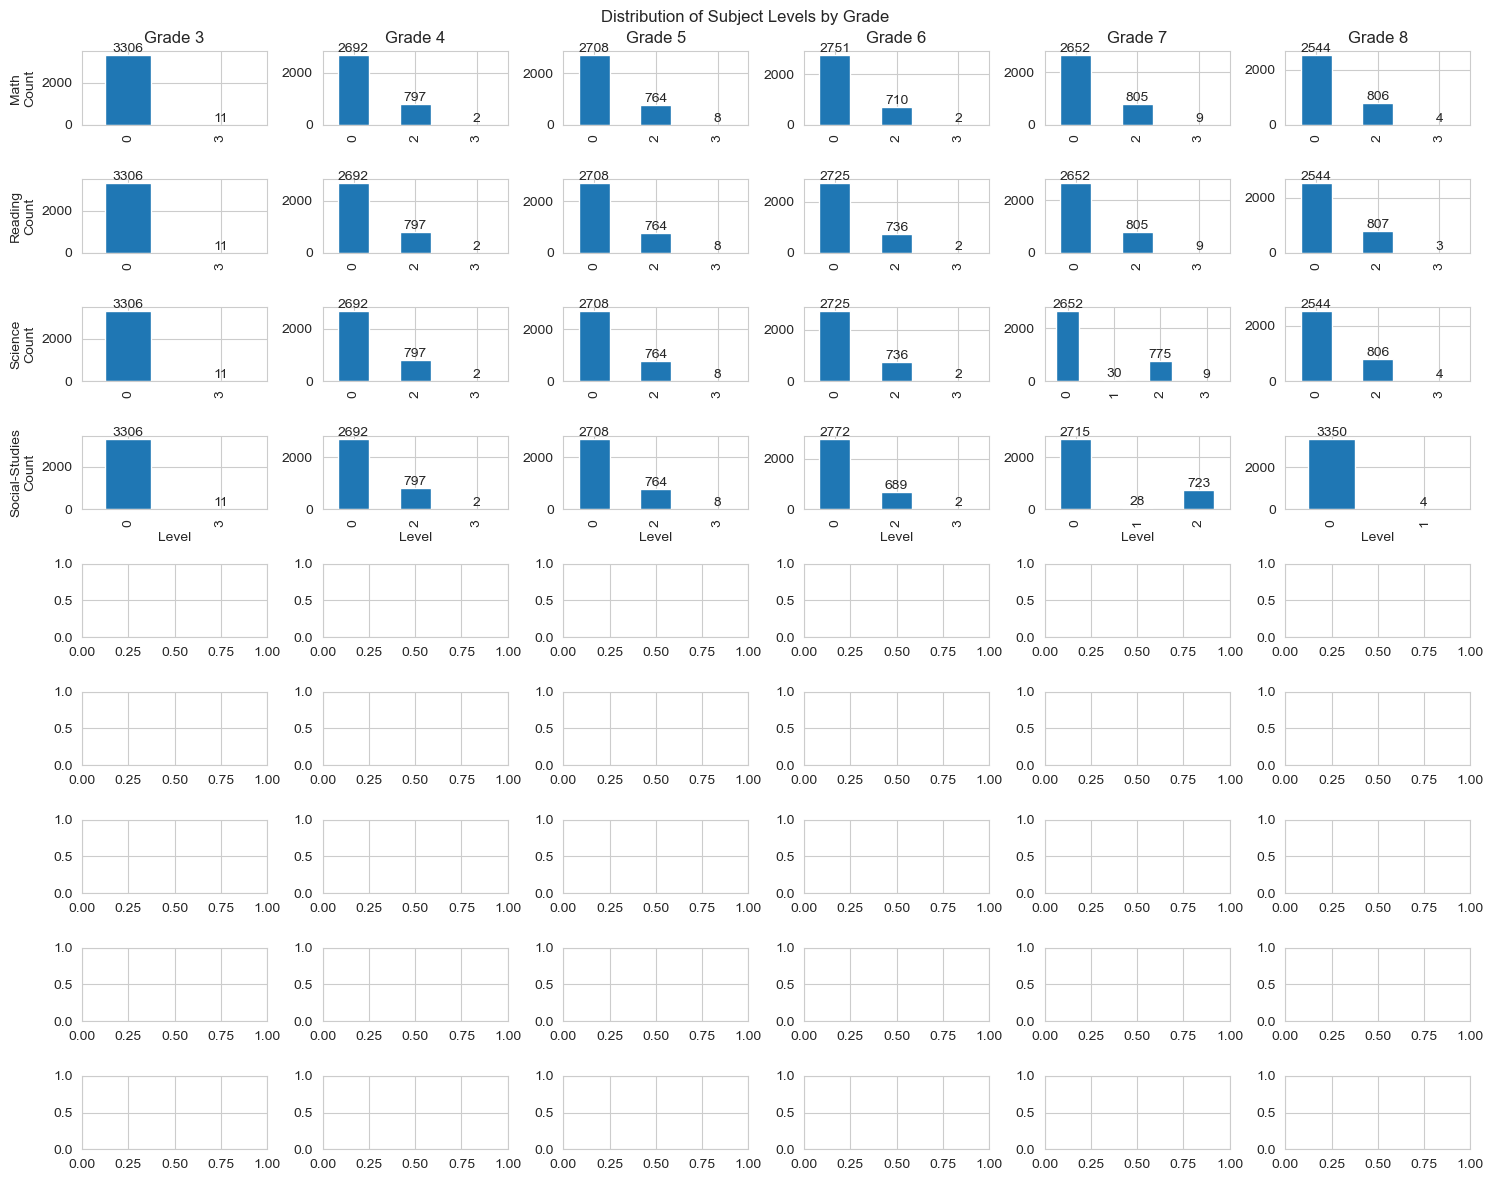

In [73]:
# Create a figure with subplots for each subject distribution
fig, axes = plt.subplots(len(subject_cols), len(set(scantronMath_38_encoded_df['level'])), figsize=(15, 12))
fig.suptitle('Distribution of Subject Levels by Grade')

subjects = ['math', 'reading', 'science', 'social-studies']
grade_levels = sorted(scantronMath_38_encoded_df['level'].unique())

for i, subject in enumerate(subjects):
    col = f'subject_{subject}'
    
    for j, grade in enumerate(grade_levels):
        ax = axes[i,j]
        
        # Filter for just this grade level
        grade_df = scantronMath_38_encoded_df[scantronMath_38_encoded_df['level'] == grade]
        
        # Create value counts and plot as bar chart
        value_counts = grade_df[col].value_counts().sort_index()
        value_counts.plot(kind='bar', ax=ax)
        
        if i == 0:
            ax.set_title(f'Grade {grade}')
        if j == 0:
            ax.set_ylabel(f'{subject.title()}\nCount')
        if i == len(subjects)-1:
            ax.set_xlabel('Level')
            
        # Add value labels on top of bars
        for k, v in enumerate(value_counts):
            ax.text(k, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [74]:
scantronMath_38_encoded_df.to_csv('dataframes/scantronMath_38_encoded.csv', index=False)
scantronReading_38_encoded_df.to_csv('dataframes/scantronReading_38_encoded.csv', index=False)